In [6]:
from ML_Dataset_Model import *
from ML_Functions import *
from Ariel_Functions import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import leastsq
import h5py 
# import os
from tqdm.notebook import tqdm
from time import time
import scipy
import torch
from torch import nn
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

In [7]:
heads = ['planet_radius' ,	'planet_temp', 	'log_H2O', 	'log_CO2', 	'log_CO' ,	'log_CH4' 	,'log_NH3']
aux_heads = ['star_distance','star_mass_kg','star_radius_m','star_temperature','planet_mass_kg','planet_orbital_period','planet_distance','planet_surface_gravity']

In [8]:
# Loads the data using numpy files from path, comment this cell and uncomment the previous cell to use the training data in the original
# format, assuming AuxillaryTable,QuartilesTable, SpectralData are all in a folder named TrainingData

# Loads the data using numpy files from path, comment this cell and uncomment the previous cell to use the training data in the original
# format, assuming AuxillaryTable,QuartilesTable, SpectralData are all in a folder named TrainingData

R_j = 71492*1e3
data = torch.load('tr_data.pt')
quart_tr = torch.Tensor(data['Quart_tr'])
safe = ~torch.isnan(quart_tr[:,0,0])
quart_tr = quart_tr[safe] # Only some of them have retrievals

spec = torch.Tensor(data['Spectra'])[safe]
noise = torch.Tensor(data['Noise'])[safe]
aux = torch.Tensor(data['Aux'])[safe]
fm = torch.Tensor(data['FM'])[safe]
param = torch.load('params_fixed.pt')
torch.manual_seed(0)
R_j = 71492*1e3
ind= torch.rand(safe.sum())<1.1
param_RpT = torch.load('params_RpT.pt')




# # # Rp and T prediction Part, Currently Utilized 

In [9]:

def preprocessor_RpT(spec,aux,noise,ind=None,std_mn=None):

    # Modifying outliers
    for i in range(spec.shape[0]):
        
        spec[i,spec[i,:]>0.1] = (spec[i,spec[i,:]<0.1]/noise[i,spec[i,:]<0.1]).mean()*noise[i,spec[i,:]>0.1]
    R_j = 71492*1e3
    Rpj = torch.sqrt(spec.min(axis=1).values*aux[:,2]**2/R_j**2)
    Rp = Rpj.clone()*R_j
    
    # Calculate R_p/R_s for the next steps
    temp = ((Rp/aux[:,2]))[:,None]
    
    # Calculating the effective temperature and the scale height
    T = aux[:,3]*(1/2*aux[:,2]/(aux[:,6]*149597870.7*1000))**(1/2)
    H = 1.380649* T / (2.29*1.66054e-4*aux[:,7])
    
    # Getting rid of the bulk planet contribution
    spec_ = spec.clone()
    spec = (spec - temp**2)
    
    # Concatenate three unitless features to the auxillary data
    aux = torch.cat((aux,Rp[:,None],(Rp/aux[:,2])[:,None],fm,
                        (aux[:,6]/H)[:,None],spec.max(axis=1).values[:,None] ,aux[:,2][:,None]/H[:,None]  ),axis=1) # *

    # Normalization of noise and spectra
    noise = noise/spec.max(axis=1).values[:,None]
    spec = spec/spec.max(axis=1).values[:,None]
    spec = torch.cat([spec,spec_],axis=1)
    # Calculate std and mean for the auxillary data if it is the training phase
    if std_mn is None:
        aux_std,aux_mn = aux[ind].std(axis=0),aux[ind].mean(axis=0)
        std_mn = [aux_std,aux_mn]
    
    else:
        aux_std,aux_mn = std_mn
       
    # Standardize the auxillary data
    aux = standardize(aux,aux_mn,aux_std) 
    
    return spec,aux,noise,Rpj,T,std_mn

class RpT_ML(nn.Module):
    def __init__(self,alpha,Dropout=0):
        super(RpT_ML, self).__init__()
        activation = nn.LeakyReLU
        self.main_layer=construct_FNN([192,192,192,64,len(alpha[0])],activation=activation,output_activation=nn.Sigmoid,Dropout=Dropout)
        self.alpha=alpha
    def forward(self, input1, input2,input3): #input1:spectra, input2: auxxilary, input3:noise


        # return self.main_layer(torch.cat((input3,input2,input1),axis=1 ) ).reshape(input1.shape[0],*self.std.shape[1:])*self.std+self.mn
        return  self.main_layer(torch.cat((input3,input2,input1),axis=1 ) ).reshape(input1.shape[0],len(self.alpha[0]))*self.alpha[1]+self.alpha[0]


In [10]:
spec_tr,aux_tr,noise_tr,Rp,T,std_mn_RpT = preprocessor_RpT(spec,aux,noise,ind=ind)
aux_std,aux_mn = std_mn_RpT
param_tr = torch.cat([quart_tr[:,1,:2],param_RpT[:,:2]],axis=1).clone()


param_mn,param_std = param_tr[ind].mean(axis=0)[None],param_tr[ind].std(axis=0)[None]


In [11]:
train_data = Combined_Quart_Dataset(spectra=spec_tr[ind],aux=aux_tr[ind],quart=param_tr[ind],noise=noise_tr[ind])
train_loader = DataLoader(train_data, batch_size=64,
                        shuffle=True, num_workers=0)

if not(ind.all()):
    test_data = Combined_Quart_Dataset(spectra=spec_tr[~ind],aux=aux_tr[~ind],quart=param_tr[~ind],noise=noise_tr[~ind])

else:
    test_data=train_data
    
test_loader = DataLoader(test_data, batch_size=len(test_data),
                        shuffle=True, num_workers=0)


In [12]:
def solve_quadratic(params):
    return torch.where( params[:,[0]].abs()>0,torch.stack([
        (-params[:,1]+(params[:,1]**2-4*params[:,2]*params[:,0]).sqrt())/(2*params[:,0]),
        (-params[:,1]-(params[:,1]**2-4*params[:,2]*params[:,0]).sqrt())/(2*params[:,0])],axis=1),
                       (-params[:,2]/params[:,1])[:,None].broadcast_to(params.shape[0],2))

def find_max_x(y,yhat):
    m1,std1=torch.split(y,[1,1],dim=1)
    m2,std2=torch.split(yhat,[1,1],dim=1)
    a=(1/std2**2-1/std1**2)
    b=2*(m1/std1**2-m2/std2**2)
    c=2*torch.log(std2/std1)+(m2**2/std2**2-m1**2/std1**2)

    x = solve_quadratic(torch.cat([a,b,c],dim=1))
    return (1-(torch.erf( (x-m1)/(std1*1.414) )-torch.erf( (x-m2)/std2*1/1.414 )).abs().max(axis=1).values*1/2)
    

In [13]:
param_tr.max(axis=0).values

tensor([2.2607e+00, 5.1475e+03, 7.7416e-03, 2.1927e+02])

In [14]:
param_tr.min(axis=0).values

tensor([1.3317e-01, 1.0758e+02, 2.5972e-06, 1.7071e-01])

In [15]:
torch.manual_seed(0)
alpha=[torch.tensor([0.001,100,0.00001,0.0001]),torch.tensor([2.5,6000,0.1,300])]
# alpha=[torch.tensor([0.001,100,-5,-2]),torch.tensor([2.5,6000,-8,8])]

model_RpT = RpT_ML(alpha,Dropout=.0)
# model_RpT = RpT_ML(0,torch.ones(1,3),Dropout=.1)

/home/e_/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:
torch.zeros(4)*alpha[1]+alpha[0]

tensor([1.0000e-03, 1.0000e+02, 1.0000e-05, 1.0000e-04])

In [17]:
torch.ones(4)*alpha[1]+alpha[0]

tensor([2.5010e+00, 6.1000e+03, 1.0001e-01, 3.0000e+02])

In [18]:
scale = torch.tensor([2.5,6000,0.1,300])

# def loss_fn(y,yhat):
#     return ((y[:,:2]-yhat[:,:2])**2+(yhat[:,2:4]-yhat[:,2:4])**2).sqrt()/scale[None,:2]

# def loss_fn(y,yhat):
#     return 1-(find_max_x(y[:,[0,2]],torch.stack([yhat[:,0],torch.exp(yhat[:,2])],dim=-1))+
#               find_max_x(y[:,[1,3]],yhat[:,[1,3]]))/2

def loss_fn(y,yhat):
    return 1-find_max_x(y[:,[1,3]],yhat[:,[1,3]])

# def loss_fn(y,yhat):
#     return 1-(find_max_x(y[:,[1,3]],torch.stack([yhat[:,1],torch.exp(yhat[:,3])],dim=-1)))
            
epochs=np.array([20,20,30])
# lrs=np.array([5e-3,2.5e-3,8e-4])
lrs=np.array([5e-4,2.5e-4,1e-4])

params={'model':model_RpT ,
      'loss_fn':loss_fn,
      'train_dl':train_loader,
      'val_dl':test_loader,
      'device':'cpu', 'optimizer':torch.optim.Adam(model_RpT.parameters(),5e-3),'lrs':lrs,'epochs':epochs}

a=train(**params)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Time total: 113.50 sec, Best Val. Loss:0.141713149439482


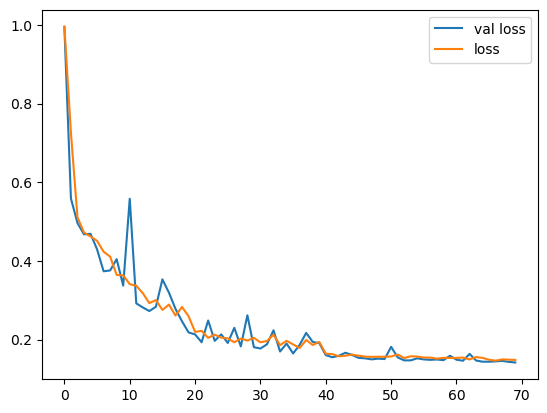

In [19]:
model_RpT.eval()
plt.plot(a['history']['val_loss'],label='val loss')
plt.plot(a['history']['loss'],label='loss')
plt.legend()

# Regular Stuff

In [21]:
R_j = 71492*1e3
def construct_FNN(layers,activation=nn.ReLU,output_activation=None,Dropout = None):
    layer = [j for i in layers for j in [nn.LazyLinear(i),activation()] ][:-1]
    if Dropout:
        layer.insert(len(layer)-2,nn.Dropout(Dropout))
    if output_activation is not None:
        layer.append(output_activation())
    return nn.Sequential(*layer)

In [22]:
class Parameter_ML(nn.Module):
    def __init__(self,Dropout=0):
        activation = nn.LeakyReLU
        super(Parameter_ML, self).__init__()
    
        self.attention_layer = construct_FNN([64,64,52],activation=activation)
        
        self.aux_layer =  construct_FNN([64,64,64],activation=activation)
        
        
        self.main_layer = construct_FNN([192,384,384,20],output_activation=nn.Sigmoid,Dropout=Dropout,activation=activation)
        
        # nn.Sequential( nn.LazyLinear( out_features = 192), activation(),
        #                 nn.Linear(in_features=192, out_features = 384), activation(), nn.Linear(in_features=384, out_features = 384)
        #                 ,nn.Dropout(Dropout),activation() ,nn.Linear(in_features=384, out_features = 20),nn.Sigmoid()) 

        self.noise_layer = construct_FNN([64,64,52],activation=activation)

    def forward(self, input1, input2,input3): #input1:spectra, input2: auxxilary, input3:noise


        a = input1*self.noise_layer(torch.cat((input3,input2,input1),axis=1 ) )
        b=torch.cat( (a*self.attention_layer(a),self.aux_layer(input2) ) ,axis=1 )
        return self.main_layer(b).reshape(a.shape[0],4,5) *torch.Tensor([1,11,11,-6])[None,:,None]-torch.Tensor([0,12,12,-6])[None,:,None]


class Conv_ML(nn.Module):
    def __init__(self,Dropout=0):
        activation = nn.LeakyReLU
        super(Conv_ML, self).__init__()

        self.spec_layer =nn.Sequential(nn.Conv1d(2,16,kernel_size=3),activation(),
                                      nn.Conv1d(16,16,kernel_size=3),activation(),nn.Conv1d(16,16,kernel_size=3),activation(),
                                      nn.Conv1d(16,16,kernel_size=3),activation(),nn.Conv1d(16,16,kernel_size=3),nn.Flatten(),nn.Dropout(.1))
        self.aux_layer = construct_FNN([64,64,64,64])
        self.main_layer = construct_FNN([512,256,128,20],output_activation=nn.Sigmoid)
        

    def forward(self, input1, input2,input3): #input1:spectra, input2: auxxilary, input3:noise
        spec_ = self.spec_layer(torch.stack([input1,input3],dim=1))
        return self.main_layer(torch.cat([self.aux_layer(input2),spec_],axis=1)).reshape(input1.shape[0],4,5) *torch.Tensor([1,11,11,-6])[None,:,None]-torch.Tensor([0,12,12,-6])[None,:,None]



In [23]:
def preprocessor(spec,aux,noise,ind=None,std_mn=None):

    # Modifying outliers
    for i in range(spec.shape[0]):
        
        spec[i,spec[i,:]>0.1] = (spec[i,spec[i,:]<0.1]/noise[i,spec[i,:]<0.1]).mean()*noise[i,spec[i,:]>0.1]
    R_j = 71492*1e3

    # Rpj = np.sqrt(aux[:,4]/aux[:,-1])*np.sqrt(6.6743*1e-11)/R_j
    Rp = torch.sqrt(spec.min(axis=1).values)*aux[:,2]
    Rpj =Rp.clone()/R_j
    
    
    # x = (np.sqrt(aux[:,4]/aux[:,-1])*np.sqrt(6.6743*1e-11)).clone().detach().numpy()
    # y = (torch.sqrt(spec.min(axis=1).values)*aux[:,2]).clone().detach().numpy()
    # ind = np.logical_and((1-x/y)>.05,(1-x/y)<.10 )
    # Rp = torch.from_numpy(np.where(ind,x,y))#y.clone()
    # Rpj = torch.tensor(Rp/R_j)
    
    
    # Calculate R_p/R_s for the next steps
    temp = ((Rp/aux[:,2]))[:,None]
    

    # Calculating the effective temperature and the scale height
    T = aux[:,3]*(1/2*aux[:,2]/(aux[:,6]*149597870.7*1000))**(1/2)
    H = 1.380649* T / (2.29*1.66054e-4*aux[:,7])
    
    # Getting rid of the bulk planet contribution
    
    
    spec = (spec - temp**2)
    spec[spec<0] = 1e-4
    # Concatenate three unitless features to the auxillary data
    aux = torch.cat((aux,Rp[:,None],(Rp/aux[:,2])[:,None],
                        (aux[:,6]/H)[:,None],spec.max(axis=1).values[:,None],aux[:,2][:,None]/H[:,None]  ),axis=1) # *

    # Normalization of noise and spectra
    noise = noise/spec.max(axis=1).values[:,None]
    spec = spec/spec.max(axis=1).values[:,None]

    # Calculate std and mean for the auxillary data if it is the training phase
    if std_mn is None:
        aux_std,aux_mn = aux[ind].std(axis=0),aux[ind].mean(axis=0)
        std_mn = [aux_std,aux_mn]
    
    else:
        aux_std,aux_mn = std_mn
       
    # Standardize the auxillary data
    aux = standardize(aux,aux_mn,aux_std) 
    
    return spec,aux,noise,Rpj,T,std_mn


In [24]:
spec_tr,aux_tr,noise_tr,Rp,T,std_mn = preprocessor(spec,aux,noise,ind=ind)
aux_std,aux_mn = std_mn
param_tr = torch.tensor(param).clone()

param_mn,param_std = param_tr[ind,:,:].mean(axis=0),param_tr[ind,:,:].std(axis=0)

In [25]:
train_data = Combined_Quart_Dataset(spectra=spec_tr[ind],aux=aux_tr[ind],quart=param_tr[ind][:,:,:],noise=noise_tr[ind])
train_loader = DataLoader(train_data, batch_size=64,
                        shuffle=True, num_workers=0)

if not(ind.all()):
    test_data = Combined_Quart_Dataset(spectra=spec_tr[~ind],aux=aux_tr[~ind],quart=param_tr[~ind][:,:,:],noise=noise_tr[~ind])

else:
    test_data=train_data
    
test_loader = DataLoader(test_data, batch_size=len(test_data),
                        shuffle=True, num_workers=0)


In [26]:
torch.manual_seed(0)
model = Parameter_ML(Dropout=0)
# model = Conv_ML()#(Dropout=.1)

In [27]:
# Loss function is an approximation of the EMD

# loss_fn = lambda y,yhat: (yhat[:,0]-y[:,0])**2+(1-y[:,0])**2*torch.abs(y[:,1]-yhat[:,1])**2+(
#     y[:,0])**2* ((y[:,2]-yhat[:,2])**2+yhat[:,3]+y[:,3]-2*torch.sqrt(y[:,3]*yhat[:,3]))

loss_fn = lambda y,yhat: (yhat[:,0]-y[:,0]).abs()*1.5+(1-y[:,0]).abs()*torch.abs(y[:,1]-yhat[:,1]).abs()+(
    y[:,0])* ((y[:,2]-yhat[:,2])**2+ (torch.sqrt(y[:,3]+1e-7)-torch.sqrt(yhat[:,3]+1e-7) )**2 ).sqrt()


epochs=np.array([20,15,5])

lrs=np.array([5e-4,2.5e-4,1e-4])
epochs=np.array([20,25,5])
# lrs=np.array([5e-3,2.5e-3,1e-3])
params={'model':model ,
      'loss_fn':loss_fn,
      'train_dl':train_loader,
      'val_dl':test_loader,
      'device':'cpu', 'optimizer':torch.optim.Adam(model.parameters(),5e-4),'lrs':lrs,'epochs':epochs}

a=train(**params)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Time total: 92.88 sec, Best Val. Loss:0.3146660042275215


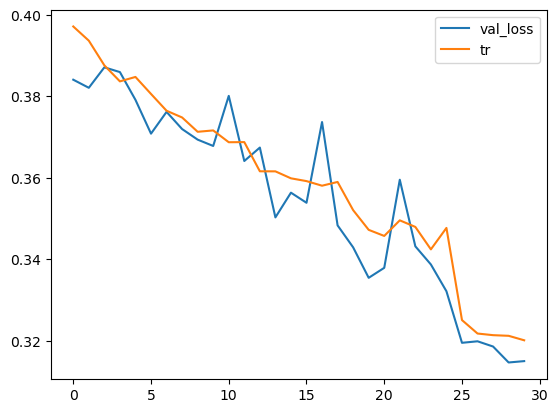

In [28]:
model.eval()
# model.load_state_dict(a['state'])
with torch.no_grad():params_test = model(spec_tr,aux_tr,noise_tr).numpy()
plt.plot(a['history']['val_loss'][20:],label='val_loss')
plt.plot(a['history']['loss'][20:],label='tr')
plt.legend()

# Calculates a part of the score 

In [23]:
# ind[:]=True
torch.manual_seed(0)
ind_score = ind.clone()
if ind.all():
    torch.manual_seed(0)
    ind_score[torch.rand(safe.sum())>.0.84625788 0.26208]=False 
t2,w2 = to_matrix('../TrainingData/Ground Truth Package/Tracedata.hdf5',torch.where(safe)[0][torch.where(~ind_score)[0]])

In [24]:
ind.sum()

tensor(6766)

In [26]:
# spec_test,aux_test,noise_test,Rp,T,std_mn =  preprocessor(spec,aux,noise,std_mn=std_mn)
# model.eval()
# with torch.no_grad():params_test = model(spec_test,aux_test,noise_test).detach().numpy()
params_test = torch.rand(spec.shape[0],4,5).detach().numpy()
spec_test,aux_test,noise_test,Rp,T,std_mn_RpT =  preprocessor_RpT(spec,aux,noise,std_mn=std_mn_RpT)
model_RpT.eval()
with torch.no_grad():RpThat = model_RpT(spec_test,aux_test,noise_test).detach()


In [27]:
real = torch.stack([quart_tr[:,1,:2],(quart_tr[:,2,:2]-quart_tr[:,0,:2])/2],dim=1).mT

In [28]:

q_Rp  = RpThat[:,[0,2]]

q_T   = RpThat[:,[1,3]]

q_RpT = torch.stack([q_Rp,q_T],-1).swapaxes(1,2)


W,y_dist = sample_fast(params_test[~ind_score],q_RpT[~ind_score])

np.int = int
w = np.zeros((len(W),7))
for i in tqdm(range(len(W))):
    w[i] = compute_posterior_loss(y_dist[i].T, W[i], t2[i], w2[i], bounds_matrix=None)
print(w.mean(axis=0))
print(w.mean())

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

[0.00248734 0.84625788 0.26200947 0.25489697 0.33133264 0.24804249
 0.2509926 ]
0.31371705614888445


In [30]:
data = torch.load('tr_data.pt')
quart_tr = torch.Tensor(data['Quart_tr'])
safe = ~torch.isnan(quart_tr[:,0,0])

spec = torch.Tensor(data['Spectra'])
noise = torch.Tensor(data['Noise'])
aux = torch.Tensor(data['Aux'])
fm = torch.Tensor(data['FM'])
param = torch.load('params_fixed.pt')
param_RpT = torch.load('params_RpT.pt')

spec_test,aux_test,noise_test,Rp,T,std_mn_RpT =  preprocessor_RpT(spec,aux,noise,std_mn=std_mn_RpT)

model_RpT.eval()
with torch.no_grad():param_RpT = model_RpT(spec_test,aux_test,noise_test).detach()#[:,[1,3]]


torch.save(param_RpT[~safe],'semi_That')
# q_RpT[:,2]=q_RpT[:,0]*.1
# q_RpT[:,-1][q_RpT[:,-1]<-1]=-1

# cov = convert_cov(q_RpT)